# Progetto Corò Elia

In [5]:
# Import libraries
# Standard Libraries
import os
import itertools
import numpy as np
import pandas as pd
from collections import Counter
import itertools

# Scientific Computing Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

# Scikit-learn Libraries
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.semi_supervised import LabelPropagation
from sklearn.utils.class_weight import compute_sample_weight

# LightGBM
import lightgbm as lgb

# TensorFlow/Keras Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

# Custom Utilities & Cleaning Functions
from utils.print_confusion_matrix import print_confusion_matrix
from utils.print_correlation_matrix import PrintCorrelationMatrix
from utils.plot_features_with_outliers import plot_features_with_outliers

from utils.rfe_selection import rfe_selection
from utils.rfecv_selection import rfecv_selection
from utils.fill_missing_values import fill_missing_values
from utils.remove_high_missing_fields import remove_high_missing_fields
from utils.remove_high_missing_columns import remove_high_missing_columns
from utils.one_hot_encoder import one_hot_encoder

models = []
ids = []

# Descrizione del Dataset

Descrizione delle varie features contenute all'interno del dataset:

---

## **Identificatore**

- **id** -> (string) ID del partecipante

---

## **Demografia**

- **Basic_Demos-Enroll_Season** -> (string) Stagione di iscrizione (Primavera, Estate, Autunno, Inverno)  
- **Basic_Demos-Age** -> (float) Età del partecipante  
- **Basic_Demos-Sex** -> (int categoriale) Sesso del partecipante (0 = Maschio, 1 = Femmina)

---

## **Child Global Assessment Scale (CGAS)**

- **CGAS-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **CGAS-CGAS_Score** -> (int) Punteggio della Scala di Valutazione Globale del Bambino (CGAS)

---

## **Misure fisiche**

- **Physical-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **Physical-BMI** -> (float) Indice di Massa Corporea (kg/m^2)  
- **Physical-Height** -> (float) Altezza (in)  
- **Physical-Weight** -> (float) Peso (lbs)  
- **Physical-Waist_Circumference** -> (int) Circonferenza vita (in)  
- **Physical-Diastolic_BP** -> (int) Pressione sanguigna diastolica (mmHg)  
- **Physical-HeartRate** -> (int) Frequenza cardiaca (battiti/min)  
- **Physical-Systolic_BP** -> (int) Pressione sanguigna sistolica (mmHg)

---

## **FitnessGram Vitals and Treadmill**

- **Fitness_Endurance-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **Fitness_Endurance-Max_Stage** -> (int) Massimo stadio raggiunto  
- **Fitness_Endurance-Time_Mins** -> (int) Tempo esatto completato: Minuti  
- **Fitness_Endurance-Time_Sec** -> (int) Tempo esatto completato: Secondi

---

## **FitnessGram Child**

- **FGC-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **FGC-FGC_CU** -> (int) Numero totale di curl up  
- **FGC-FGC_CU_Zone** -> (int categoriale) Zona di fitness curl up (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_GSND** -> (float) Forza di presa totale (non dominante)  
- **FGC-FGC_GSND_Zone** -> (int categoriale) Zona di fitness forza di presa (non dominante) (1 = Debole, 2 = Normale, 3 = Forte)  
- **FGC-FGC_GSD** -> (float) Forza di presa totale (dominante)  
- **FGC-FGC_GSD_Zone** -> (int categoriale) Zona di fitness forza di presa (dominante) (1 = Debole, 2 = Normale, 3 = Forte)  
- **FGC-FGC_PU** -> (int) Numero totale di push-up  
- **FGC-FGC_PU_Zone** -> (int categoriale) Zona di fitness push-up (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_SRL** -> (float) Totale sit & reach (lato sinistro)  
- **FGC-FGC_SRL_Zone** -> (int categoriale) Zona di fitness sit & reach (lato sinistro) (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_SRR** -> (float) Totale sit & reach (lato destro)  
- **FGC-FGC_SRR_Zone** -> (int categoriale) Zona di fitness sit & reach (lato destro) (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_TL** -> (int) Totale trunk lift  
- **FGC-FGC_TL_Zone** -> (int categoriale) Zona di fitness trunk lift (0 = Necessita miglioramenti, 1 = Zona di fitness sana)

---

## **Bioelectrical Impedance Analysis**

- **BIA-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **BIA-BIA_Activity_Level_num** -> (int categoriale) Livello di attività (1 = Molto leggera, 2 = Leggera, 3 = Moderata, 4 = Pesante, 5 = Eccezionale)  
- **BIA-BIA_BMC** -> (float) Contenuto Minerale Osseo  
- **BIA-BIA_BMI** -> (float) Indice di Massa Corporea  
- **BIA-BIA_BMR** -> (float) Metabolismo Basale  
- **BIA-BIA_DEE** -> (float) Dispendio Energetico Giornaliero  
- **BIA-BIA_ECW** -> (float) Acqua Extracellulare  
- **BIA-BIA_FFM** -> (float) Massa Magra  
- **BIA-BIA_FFMI** -> (float) Indice Massa Magra  
- **BIA-BIA_FMI** -> (float) Indice di Massa Grassa  
- **BIA-BIA_Fat** -> (float) Percentuale di Grasso Corporeo  
- **BIA-BIA_Frame_num** -> (int categoriale) Struttura corporea (1 = Piccola, 2 = Media, 3 = Grande)  
- **BIA-BIA_ICW** -> (float) Acqua Intracellulare  
- **BIA-BIA_LDM** -> (float) Massa Secca Magra  
- **BIA-BIA_LST** -> (float) Tessuto Molle Magro  
- **BIA-BIA_SMM** -> (float) Massa Muscolare Scheletrica  
- **BIA-BIA_TBW** -> (float) Acqua Corporea Totale

---

## **Physical Activity Questionnaire (Adolescents)**

- **PAQ_A-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **PAQ_A-PAQ_A_Total** -> (float) Punteggio totale attività (Adolescenti)

---

## **Physical Activity Questionnaire (Children)**

- **PAQ_C-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **PAQ_C-PAQ_C_Total** -> (float) Punteggio totale attività (Bambini)

---

## **Sleep Disturbance Scale**

- **SDS-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **SDS-SDS_Total_Raw** -> (int) Punteggio totale grezzo  
- **SDS-SDS_Total_T** -> (int) Punteggio totale T

---

## **Internet Use**

- **PreInt_EduHx-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **PreInt_EduHx-computerinternet_hoursday** -> (int categoriale) Ore di utilizzo del computer/internet (0 = Meno di 1h/giorno, 1 = Circa 1h/giorno, 2 = Circa 2h/giorno, 3 = Più di 3h/giorno)


# Processo di pulizia e manipolazione del dataset

## **Pre-Training**

1. **Lettura del dataset e rimozione delle colonne non presenti nel test set e le colonne season**  
   Caricamento dei dati da file ed eliminazione delle features non presenti nel test set e di tutte le colonne season.

2. **Rimozione delle righe con troppi valori mancanti**  
   Rimozione delle righe con una percentuale elevata di dati mancanti.

3. **Pulizia delle istanze sporche**  
   Sostituzione o rimozione dei valori anomali o errati.

4. **Standardizzazione delle colonne numeriche**  
   Standardizzazione delle variabili numeriche.

5. **One Hot Encoding delle variabili categoriali**  
   Conversione delle variabili categoriali in numeriche tramite One Hot Encoding.

6. **Split train e test**  
   Divisione tra il dataset di training e di test ponendo particolare attenzione a mettere nel test istanze con sii != NaN.

7. **Gestione dei valori mancanti**  
   Riempimento dei valori mancanti.

8. **Label Propagation per le y mancanti**  
   Stima delle etichette mancanti tramite Label Propagation.

9. **Analisi della correlazione tra le features**  
   Rimozione o combinazione delle feature altamente correlate.

10. **Analisi della distribuzione delle etichette e baseline accuracy**  
   Analisi dello sbilanciamento delle etichette e definizione di un algoritmo di scoring e calcolo della baseline accuracy.
---

## **Training dei Modelli**

1. **Random Forest**  

2. **Artificial Neural Network (ANN)**  

3. **LightGBM**


## Data Initial Cleaning

In [6]:
def pre_processing(data):
    threshold = 0.9
    # Mantieni solo le colonne presenti nel set di test
    test_columns = list(pd.read_csv('data/test.csv').columns) + ['sii']
    data = data[test_columns]
    
    # Rimuovi tutte le colonne season
    season_col = [col for col in data.columns if 'Season' in col]
    data = data.drop(columns=season_col)
    print(f"Colonne season rimosse: {len(season_col)}")
    
    # Rimuovi colonne che superano la soglia
    data, removed_columns = remove_high_missing_columns(data, threshold=threshold)
    print(f"Colonne rimosse: con {threshold*100}% dei dati mancanti: {len(removed_columns)}, {list(removed_columns)}")
    
    # Separa le righe con 'sii' mancante senza rimuoverle
    data_with_sii = data[data['sii'].notna()]
    data_without_sii = data[data['sii'].isna()]
    
    # Rimuovi righe  che superano la soglia nel sottoinsieme con 'sii' valido
    clean_data, removed_rows = remove_high_missing_fields(data_with_sii, threshold=threshold)
    print(f"Righe rimosse con {threshold*100}% dei dati mancanti: {len(removed_rows)}")
    
    # Ricombina i dati
    data = pd.concat([clean_data, data_without_sii], ignore_index=True)
    
    # Controlla i valori mancanti in 'sii'
    missing_sii_count = data['sii'].isnull().sum()
    print(f"Numero di righe con 'sii' null: {missing_sii_count}")
    
    return data
    
# Carica i dati
data = pd.read_csv('./data/train.csv')

data = pre_processing(data)
data

Colonne season rimosse: 10
Colonne rimosse: con 90.0% dei dati mancanti: 0, []
Righe rimosse con 90.0% dei dati mancanti: 3
Numero di righe con 'sii' null: 1224


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,16.77900,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,20.90200,79.6982,35.3804,63.1265,NaN,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,fe7c87e2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3953,fe7f68a7,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,...,NaN,NaN,NaN,NaN,2.32,NaN,49.0,68.0,2.0,NaN
3954,ff0ab367,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3955,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


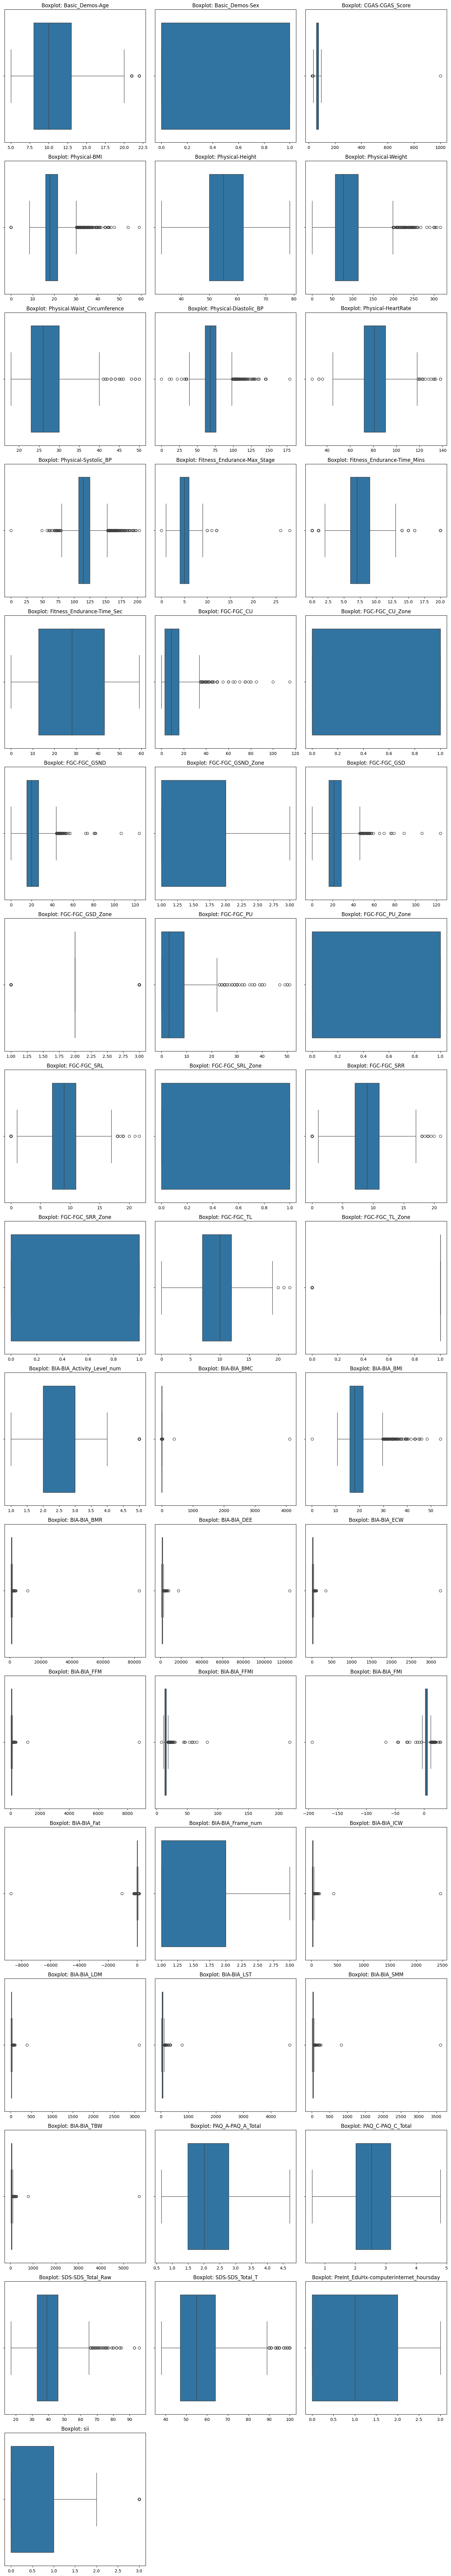

In [7]:
# Facciamo il plot dei dati numerici e vediamo se ci sono errori
plot_features_with_outliers(data)

In [8]:
def instances_cleaning(data):
    rows_to_remove = []
    
    # Non possono esserci valori troppo alti per CGAS-CGAS_Score
    rows_to_remove += data[data['CGAS-CGAS_Score'] > 800].index.tolist()
    
    # Il BMI non può essere <= 0
    rows_to_remove += data[data['Physical-BMI'] <= 0].index.tolist()

    # La pressione diastolica non può essere < 20 o > 150
    rows_to_remove += data[(data['Physical-Diastolic_BP'] < 20) | (data['Physical-Diastolic_BP'] > 150)].index.tolist()
    
    # La frequenza cardiaca non può essere inferiore a 40
    rows_to_remove += data[data['Physical-HeartRate'] < 40].index.tolist()
    
    # La pressione sistolica non può essere inferiore a 50
    rows_to_remove += data[data['Physical-Systolic_BP'] < 50].index.tolist()
    
    # Impostiamo a NaN i valori di grasso corporeo negativo, ma non rimuoviamo le righe. Ci sono troppe righe che hanno valori anomali
    data.loc[data['BIA-BIA_Fat'] < 0, 'BIA-BIA_Fat'] = np.nan
    
    # La massa muscolare scheletrica non può superare i 500
    rows_to_remove += data[data['BIA-BIA_SMM'] > 500].index.tolist()
    
    # Massa muscolare scheletrica troppo alta (> 500)
    rows_to_remove += data[data['BIA-BIA_SMM'] > 500].index.tolist()
    
    # L'acqua extracellulare non può essere troppo alta
    rows_to_remove += data[data['BIA-BIA_ECW'] > 400].index.tolist()
    
    # L'acqua intracellulare non può essere maggiore di 400
    rows_to_remove += data[data['BIA-BIA_ICW'] > 400].index.tolist()
    
    # La massa magra (Lean Soft Tissue) non può essere troppo alta
    rows_to_remove += data[data['BIA-BIA_LST'] > 4000].index.tolist()
    
    # Il totale di acqua corporea non può superare 1000
    rows_to_remove += data[data['BIA-BIA_TBW'] > 1000].index.tolist()
    
    index_counter = Counter(rows_to_remove)

    print("Numero di righe rimosse: " + str(len(rows_to_remove)))
    return data.drop(rows_to_remove)

data = instances_cleaning(data)
data


Numero di righe rimosse: 27


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,16.77900,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,20.90200,79.6982,35.3804,63.1265,NaN,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,fe7c87e2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3953,fe7f68a7,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,...,NaN,NaN,NaN,NaN,2.32,NaN,49.0,68.0,2.0,NaN
3954,ff0ab367,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3955,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


In [9]:
def standardize_dataframe(df):
    # Seleziona le colonne numeriche (escludendo 'sii')
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != 'sii']

    # Mantieni i valori originali di 'sii'
    sii_original = df['sii'].copy()

    # Standardizza le colonne numeriche
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Ripristina i valori di 'sii'
    df['sii'] = sii_original

    return df

data = standardize_dataframe(data)
data


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,-1.518441,-0.769674,-1.191370,-0.495990,-1.329983,-0.864908,NaN,NaN,NaN,...,-1.168944,-0.886599,-0.703683,-0.821287,NaN,NaN,NaN,NaN,1.774006,2.0
1,000fd460,-0.399448,-0.769674,NaN,-1.060148,-1.062520,-0.972913,-0.948969,0.400570,-0.859944,...,-0.409438,-0.868183,-0.934869,-1.077798,NaN,-0.320023,0.470315,0.472022,-0.968044,0.0
2,00105258,-0.119699,1.299252,0.504794,-0.541377,0.074200,-0.306885,NaN,-0.350867,0.912259,...,NaN,NaN,NaN,NaN,NaN,-0.536684,-0.295780,-0.284733,0.859989,0.0
3,00115b9f,-0.399448,-0.769674,0.504794,-0.215069,0.007335,-0.171880,NaN,-0.726585,1.133785,...,-0.183909,-0.193700,-0.315342,-0.215672,NaN,-0.178556,-0.966113,-0.965812,-0.968044,1.0
4,001f3379,0.719546,1.299252,-1.276178,0.576577,0.475396,0.516649,NaN,-0.726585,-0.638419,...,0.331247,0.525104,0.182815,0.564002,NaN,1.935799,-0.104256,-0.133382,-0.968044,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,fe7c87e2,0.719546,-0.769674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.906282,NaN,NaN,NaN,NaN
3953,fe7f68a7,1.279042,1.299252,NaN,0.611916,0.809725,0.755159,0.488274,-0.426010,-1.598363,...,NaN,NaN,NaN,NaN,0.169837,NaN,0.757601,0.774724,0.859989,NaN
3954,ff0ab367,-0.399448,-0.769674,NaN,0.163748,-0.460727,-0.225882,0.128963,0.400570,0.764576,...,NaN,NaN,NaN,NaN,NaN,-0.766090,NaN,NaN,-0.968044,NaN
3955,ffa9794a,-0.119699,-0.769674,NaN,-0.121299,-0.326995,-0.288884,-0.050692,-0.726585,-0.269210,...,NaN,NaN,NaN,NaN,NaN,-0.320023,NaN,NaN,-0.968044,NaN


In [10]:
data = one_hot_encoder(data, ['id', 'sii'])
data

Colonne modificate: []


,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,id,sii
0,-0.632560,-0.722473,-0.495836,-0.928108,-0.844025,-0.969400,-0.928110,-0.332508,-0.332707,-0.682296,...,NaN,-1.329983,NaN,NaN,-0.864908,1.774006,NaN,NaN,00008ff9,2.0
1,-0.632560,-0.758457,-1.060583,-0.913106,-0.832828,-1.170820,-0.913108,-0.637295,-0.768295,-0.942106,...,-0.859944,-1.062520,0.295510,-0.948969,-0.972913,-0.968044,0.470315,0.472022,000fd460,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.912259,0.074200,-0.001335,NaN,-0.306885,0.859989,-0.295780,-0.284733,00105258,0.0
3,0.339064,-0.248384,-0.214645,-0.210377,-0.117594,-0.308540,-0.210359,-0.253785,-0.059797,-0.206051,...,1.133785,0.007335,-0.001335,NaN,-0.171880,-0.968044,-0.966113,-0.965812,00115b9f,1.0
4,-0.632560,-0.051028,2.148426,0.509547,0.005336,1.008394,0.509536,0.549019,2.125190,2.229413,...,-0.638419,0.475396,-0.891868,NaN,0.516649,-0.968044,-0.104256,-0.133382,001f3379,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fe7c87e2,NaN
3953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.598363,0.809725,-0.654393,0.488274,0.755159,0.859989,0.757601,0.774724,fe7f68a7,NaN
3954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.764576,-0.460727,1.482888,0.128963,-0.225882,-0.968044,NaN,NaN,ff0ab367,NaN
3955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.269210,-0.326995,0.058034,-0.050692,-0.288884,-0.968044,NaN,NaN,ffa9794a,NaN


Oltre alla colonna **`sii`**, non sono presenti altre colonne categoriali.

In [11]:
# Separazione del dataset tra sii == NaN e sii != NaN
data_with_sii = data[data['sii'].notna()]
data_without_sii = data[data['sii'].isna()]

# Per i dati validi separiamo la variabile target e le features
X_valid = data_with_sii.drop('sii', axis=1)
y_valid = data_with_sii['sii']

# Suddivisione dei dati validi in training e test set
X_train_valid, X_test_with_encoder, y_train_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2)

# Unione dei dati senza sii al training set
X_train_with_encoder = pd.concat([X_train_valid, data_without_sii.drop('sii', axis=1)], axis=0)
y_train = pd.concat([y_train_valid, data_without_sii['sii']], axis=0)

# Salvataggio degli id dal training set per utilizzarli successivamente
ids = X_train_with_encoder['id']

# Rimozione della colonna 'id' dalle features
X_train_with_encoder = X_train_with_encoder.drop(columns=['id'])
X_test_with_encoder = X_test_with_encoder.drop(columns=['id'])


In [12]:
ids # Salviamoci tutti i dati che utilizziamo per il training, i rimanenti saranno per il test

1430    8328c8b3
1205    6e0d4774
1290    76781cd8
2568    ef58dd3c
2461    e63a0ea8
          ...   
3952    fe7c87e2
3953    fe7f68a7
3954    ff0ab367
3955    ffa9794a
3956    ffef538e
Name: id, Length: 3394, dtype: object

In [13]:
# Filling dei missing values
X_train_filled_with_encoder = fill_missing_values(X_train_with_encoder)
X_test_filled_with_encoder = fill_missing_values(X_test_with_encoder)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [14]:
X_train_with_encoder = X_train_filled_with_encoder
X_test_with_encoder = X_test_filled_with_encoder

In [15]:
def fill_y_column(X, y_column):
    # Sostituzione dei valori NaN con -1 in y_column
    # Per funzionare far funzionare la label propagation bisogna mettere -1
    y_column_filled = y_column.copy()
    y_column_filled = y_column_filled.fillna(-1)

    # Creazione e addestramento del modello di Label Propagation
    lp = LabelPropagation(kernel='rbf', n_neighbors=10, max_iter=300)
    lp.fit(X, y_column_filled)
    
    # Predizione dei valori mancanti
    y_pred = lp.predict(X)
    
    # Sostituzione dei valori predetti dove c'erano NaN
    y_column_imputed = y_column.copy()
    missing_mask = y_column.isna()
    y_column_imputed[missing_mask] = y_pred[missing_mask]

    # Conta le etichette aggiunte per ciascuna classe
    filled_counts = pd.Series(y_column_imputed[missing_mask]).value_counts()
    print("Numero di etichette aggiunte per ciascuna classe:")
    print(filled_counts)
    
    # Restituzione di y_column con i valori originali e quelli sostituiti tramite Label Propagation
    return y_column_imputed

# Sostituzione dei valori mancanti nella colonna target nei set di training e test
y_train = fill_y_column(X_train_with_encoder, y_train)


Numero di etichette aggiunte per ciascuna classe:
sii
0.0    840
1.0    201
2.0    177
3.0      3
Name: count, dtype: int64


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=300 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Dopo l'imputazione, il modello ha aggiunto molte istanze delle classi **0** e **1**, causando un possibile sbilanciamento del dataset.  
Sono state effettuate prove con e senza **Label Propagation**, e non si riscontrano differenze significative nei risultati in termini di **accuracy** e **balanced accuracy**.  



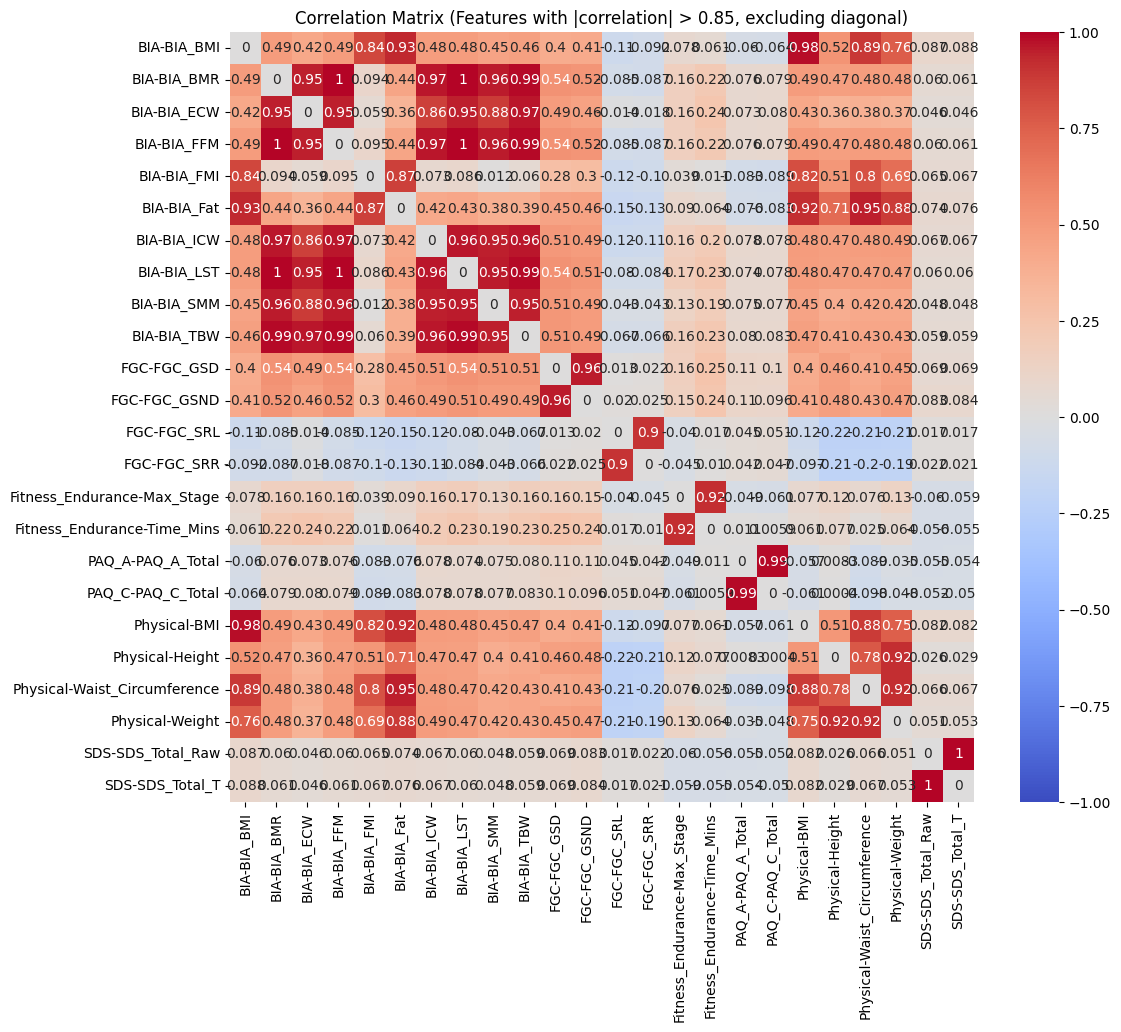

In [16]:
PrintCorrelationMatrix(X_train_with_encoder, 0.85)

## Gestione delle Correlazioni

1. **Colonne BIA-BIA**:  
   Tra le colonne **'BIA-BIA_BMR'**, **'BIA-BIA_DEE'**, **'BIA-BIA_ECW'**, **'BIA-BIA_ICW'**, **'BIA-BIA_FFM'**, **'BIA-BIA_LDM'**, **'BIA-BIA_LST'**, **'BIA-BIA_SMM'**, **'BIA-BIA_TBW'** e **'BIA-BIA_BMI'**, teniamo solo **'BIA-BIA_BMI'**.  
   - **'BIA-BIA_BMR'**: Tasso metabolico basale (calorie bruciate a riposo).  
   - **'BIA-BIA_DEE'**: Dispendio energetico giornaliero stimato.  
   - **'BIA-BIA_ECW'**: Acqua extracellulare.  
   - **'BIA-BIA_ICW'**: Acqua intracellulare.  
   - **'BIA-BIA_FFM'**: Massa magra.  
   - **'BIA-BIA_LDM'**: Massa magra degli arti.  
   - **'BIA-BIA_LST'**: Tessuto magro degli arti.  
   - **'BIA-BIA_SMM'**: Massa muscolare scheletrica.  
   - **'BIA-BIA_TBW'**: Acqua corporea totale.  
   - **'BIA-BIA_BMI'**: Indice di massa corporea calcolato tramite impedenza bioelettrica.  

   Si sceglie di mantenere solo **'BIA-BIA_BMI'** in quanto è la misura più generica e completa.

2. **Colonne fisiche**:  
   Tra **'Physical-Waist_Circumference'**, **'Physical-Weight'**, **'BIA-BIA_BMI'**, **'BIA-BIA_Fat'** e **'Physical-BMI'**, teniamo solo **'Physical-BMI'**.  
   - **'Physical-Waist_Circumference'**: Circonferenza della vita misurata fisicamente.  
   - **'Physical-Weight'**: Peso corporeo misurato direttamente.  
   - **'BIA-BIA_BMI'**: BMI calcolato con l'impedenza bioelettrica.  
   - **'BIA-BIA_Fat'**: Percentuale di grasso corporeo misurata tramite BIA.  
   - **'Physical-BMI'**: BMI ottenuto da strumenti di misurazione diretta.  

   **'Physical-BMI'** viene scelto in quanto è la misura più diretta e precisa rispetto alle altre, che sono derivate o stimate.

3. **Unione delle colonne 'FGC-FGC_SRL' e 'FGC-FGC_SRR'**:  
   - **'FGC-FGC_SRL'**: Forza di presa della mano dominante.  
   - **'FGC-FGC_SRR'**: Forza di presa della mano non dominante.  

   Creiamo la nuova colonna **'FGC-FGC_SRM'**, che rappresenta la media tra i due valori.

4. **Unione delle colonne 'FGC-FGC_GSD' e 'FGC-FGC_GSND'**:  
   - **'FGC-FGC_GSD'**: Forza specifica della mano dominante.  
   - **'FGC-FGC_GSND'**: Forza specifica della mano non dominante.  

   Creiamo la nuova colonna **'FGC-FGC_GSM'**, che rappresenta la media tra i due valori.

5. **Rimozione delle colonne _Zone**:  
   Tutte le colonne con il suffisso **'_Zone'** vengono rimosse, in quanto rappresentano categorizzazioni di altre variabili e non apportano valore aggiunto ai dati grezzi.

6. **SDS-SDS_Total_T e SDS-SDS_Total_Raw**:  
   - **'SDS-SDS_Total_T'**: Punteggio T della scala di disturbi del sonno, misura standardizzata.  
   - **'SDS-SDS_Total_Raw'**: Punteggio grezzo della scala di disturbi del sonno.  

   Manteniamo **'SDS-SDS_Total_T'**, in quanto fornisce una valutazione standardizzata.

7. **Selezione della colonna PAQ_Total**:  
   Tra **'PAQ_A-PAQ_A_Total'** e **'PAQ_C-PAQ_C_Total'**, creiamo la nuova colonna **'PAQ_Total'**, che assume il massimo tra i due valori.  
   - **'PAQ_A-PAQ_A_Total'**: Livello di attività fisica per adulti.  
   - **'PAQ_C-PAQ_C_Total'**: Livello di attività fisica per bambini/adolescenti.  

   Poiché un individuo può appartenere solo a una delle due categorie (adulto o bambino/adolescente), il valore massimo tra i due garantisce la corretta rappresentazione del livello di attività fisica del soggetto.

8. **Rimozione di Fitness_Endurance-Time_Mins**:  
   - **'Fitness_Endurance-Time_Mins'**: Tempo totale in minuti del test di resistenza.  
   - **'Fitness_Endurance-Time_Sec'**: Tempo totale in secondi del test di resistenza.  

   Poiché **'Fitness_Endurance-Time_Sec'** è una misura più dettagliata e precisa, rimuoviamo **'Fitness_Endurance-Time_Mins'**.   


In [17]:
def data_cleaning(df):
    # Eliminazione delle colonne non necessarie, mantenendo solo BIA-BIA_BMI
    to_remove = ['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM',
                 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Selezione della colonna più rappresentativa tra Physical-Waist_Circumference, Physical-Weight, BIA-BIA_BMI, BIA-BIA_Fat e Physical-BMI,
    # ovvero Physical-BMI
    # BIA-BIA_BMI -> Calcolo basato su peso e altezza
    # BIA-BIA_Fat -> Percentuale di grasso corporeo ottenuta tramite analisi dell’impedenza bioelettrica (BIA)
    # Physical-BMI -> Misurazione effettuata tramite macchinario
    to_remove = ['Physical-Waist_Circumference', 'Physical-Weight', 'BIA-BIA_Fat', 'BIA-BIA_BMI']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Calcolo della media tra FGC-FGC_SRL e FGC-FGC_SRR
    # FGC-FGC_SRL -> Forza di presa della mano dominante (dinamometro)
    # FGC-FGC_SRR -> Forza di presa della mano non dominante (dinamometro)
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(df.columns) and 'FGC-FGC_SRM' not in df.columns:
        df['FGC-FGC_SRM'] = (df['FGC-FGC_SRL'] + df['FGC-FGC_SRR']) / 2
        df = df.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR'])

    # Calcolo della media tra FGC-FGC_GSD e FGC-FGC_GSND
    # FGC-FGC_GSD -> Forza di presa della mano dominante (misurazione specifica per la forza)
    # FGC-FGC_GSND -> Forza di presa della mano non dominante (misurazione specifica per la forza)
    if {'FGC-FGC_GSD', 'FGC-FGC_GSND'}.issubset(df.columns) and 'FGC-FGC_GSM' not in df.columns:
        df['FGC-FGC_GSM'] = (df['FGC-FGC_GSD'] + df['FGC-FGC_GSND']) / 2
        df = df.drop(columns=['FGC-FGC_GSD', 'FGC-FGC_GSND'])

    # Rimozione delle colonne _Zone, rappresentanti categorizzazioni di altre colonne
    zone_col = [col for col in df.columns if '_Zone' in col]
    df = df.drop(columns=zone_col)
    print(f"Colonne _Zone rimosse: {zone_col}")

    # Calcolo del massimo tra PAQ_A-PAQ_A_Total e PAQ_C-PAQ_C_Total
    # PAQ_A-PAQ_A_Total -> Livello di attività fisica per adulti
    # PAQ_C-PAQ_C_Total -> Livello di attività fisica per bambini/adolescenti
    # Mutua esclusione tra i due valori: la presenza di uno implica la non rilevanza dell’altro
    if {'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'}.issubset(df.columns) and 'PAQ_Total' not in df.columns:
        df['PAQ_Total'] = df[['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']].max(axis=1)
        df = df.drop(columns=['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

    # Rimozione della colonna Fitness_Endurance-Time_Mins
    # Fitness_Endurance-Time_Mins -> tempo in minuti
    # Fitness_Endurance-Time_Sec -> tempo in secondi
    if 'Fitness_Endurance-Time_Mins' in df.columns:
        df = df.drop(columns=['Fitness_Endurance-Time_Mins'])
    
    # Selezione della colonna SDS-SDS_Total_T ed eliminazione di SDS-SDS_Total_Raw
    # SDS-SDS_Total_T -> Punteggio T totale della scala di disturbi del sonno (standardizzazione della qualità del sonno)
    if 'SDS-SDS_Total_Raw' in df.columns:
        df = df.drop(columns=['SDS-SDS_Total_Raw'])

    return df

X_train_with_encoder = data_cleaning(X_train_with_encoder)
X_test_with_encoder = data_cleaning(X_test_with_encoder)


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']


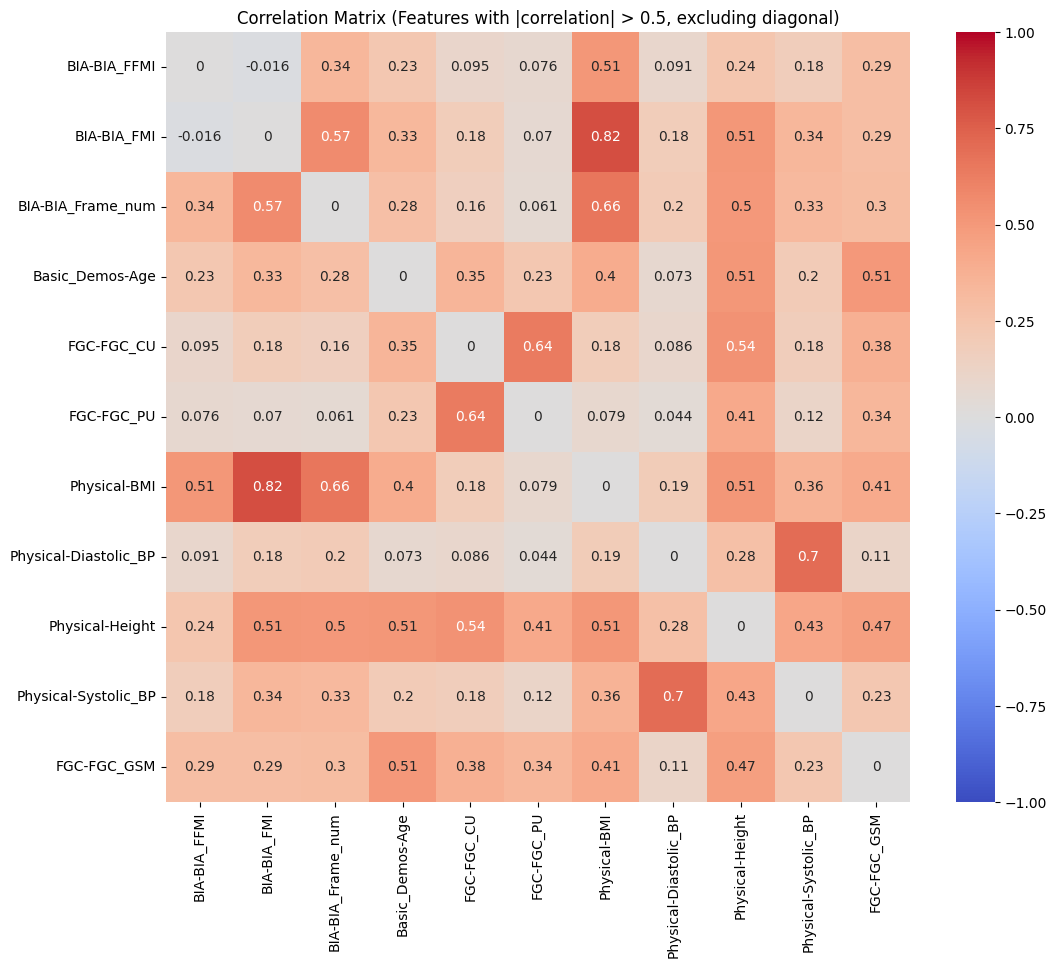

In [18]:
PrintCorrelationMatrix(X_train_with_encoder, 0.50)

## Gestione della Correlazione delle Features

La maggior parte dei problemi di correlazione tra le variabili è stata risolta. Tuttavia, permangono alcune coppie di colonne correlate:

1. **Physical-BMI** (misura la massa corporea)  
2. **BIA-BIA_FMI** (misura la massa grassa)  

Queste due variabili, pur essendo leggermente correlate, rappresentano due misurazioni distinte perciò le manteniamo separate.  

In [19]:
X_train_with_encoder

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Frame_num,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,FGC-FGC_CU,FGC-FGC_PU,...,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_T,FGC-FGC_SRM,FGC-FGC_GSM,PAQ_Total
1430,2.282313,0.768915,0.597825,-0.115406,0.373569,2.398035,-0.769674,-1.276178,0.399045,0.307302,...,0.288419,1.076863,-1.229153,1.478384,0.473617,-0.054028,-0.284733,-0.315731,0.300386,1.773303
1205,1.310689,-0.206553,0.004039,-0.193939,-1.096247,-0.119699,-0.769674,0.049374,-0.359706,-0.348779,...,-0.161527,-0.651441,0.321525,-0.092964,-1.010606,0.859989,2.136883,0.146268,-0.340633,0.610344
1290,-1.604185,-0.494568,-0.105154,0.114030,0.373569,-0.679196,-0.769674,0.419986,-0.953143,-0.754602,...,0.027514,0.550857,-0.269210,-0.661324,-0.476286,0.859989,-0.587435,-0.510152,-1.144070,0.018876
2568,1.310689,0.181608,0.114491,1.188578,0.373569,1.558791,1.299252,1.692108,1.251050,1.950885,...,1.075239,-0.200579,-1.524521,1.010323,-0.179441,-0.054028,-1.268514,1.021294,0.372495,-0.124616
2461,1.310689,0.246861,-0.250068,-0.188026,-1.096247,-0.679196,-0.769674,0.419986,-0.783589,-0.348779,...,-0.245337,0.400570,2.093729,-1.196252,-0.001335,-0.968044,-1.192839,0.656650,-0.694934,1.331812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,-0.321641,-0.253295,-0.054428,-0.416116,-0.684698,0.719546,-0.769674,0.241888,-0.868366,-0.678848,...,-0.445014,-0.283237,0.282389,-0.352618,-0.337363,-0.118009,0.093645,0.215523,-0.521766,-0.816345
3953,0.047577,-0.019997,-0.050984,0.807702,0.255984,1.279042,1.299252,-0.568030,-0.190153,-0.754602,...,0.611916,-0.426010,-1.598363,0.809725,-0.654393,0.859989,0.774724,-0.109148,-0.257066,0.400820
3954,-0.156464,-0.162956,0.054029,0.148745,0.035511,-0.399448,-0.769674,-0.139748,-0.953143,-0.754602,...,0.163748,0.400570,0.764576,-0.460727,1.482888,-0.968044,0.093645,0.145968,-0.684904,-0.737609
3955,-0.020437,-0.229505,0.019825,-0.190692,-0.037980,-0.119699,-0.769674,0.156232,-0.953143,-0.213505,...,-0.121299,-0.726585,-0.269210,-0.326995,0.058034,-0.968044,0.093645,-2.552880,-0.501955,-0.084594


In [20]:
# Conteggio della distribuzione delle etichette nel training set
train_counts = y_train.value_counts()

# Conteggio della distribuzione delle etichette nel test set
test_counts = y_test.value_counts()

# Visualizzazione della distribuzione delle etichette nel training set
print("Distribuzione delle etichette nel training set:")
print(train_counts)

# Visualizzazione della distribuzione delle etichette nel test set
print("Distribuzione delle etichette nel test set:")
print(test_counts)


Distribuzione delle etichette nel training set:
sii
0.0    2111
1.0     781
2.0     473
3.0      29
Name: count, dtype: int64
Distribuzione delle etichette nel test set:
sii
0.0    314
1.0    146
2.0     76
3.0      8
Name: count, dtype: int64


In [21]:
# Funzione per calcolare l'accuratezza bilanciata inversa
def inverse_balanced_accuracy(y_true, y_pred):
    # Converte le etichette in array di interi
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    
    # Calcola la frequenza di ciascuna classe nel dataset
    class_counts = np.bincount(y_true)
    total_samples = len(y_true)
    
    # Calcola la frequenza inversa di ciascuna classe
    class_weights = total_samples / class_counts
    # Normalizza i pesi affinché la somma totale sia 1
    class_weights = class_weights / np.sum(class_weights)

    # Assegna un peso ad ogni campione in base alla sua classe
    sample_weights = class_weights[y_true]

    # Calcola l'accuratezza bilanciata utilizzando i pesi per compensare il bilanciamento delle classi
    acc = balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weights)
    
    return acc

Il dataset è fortemente sbilanciato.  
Per la valutazione dei modelli utilizziamo una metrica basata su una media ponderata, dove i pesi sono calcolati in base all'inversa della proporzionalità della classe nel dataset.
Evitiamo quindi di focalizzarci sulle classi 0 e 1.

In [22]:
baseline_accuracy = y_train.value_counts().max() / len(y_train)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")


Baseline Accuracy: 0.6220


## Random Forest
Aggiungiamo la selezione automatica delle feature tramite RFECV per utilizzare solo le colonne più rilevanti del dataset, riducendo così il rumore.

In [23]:
# Selezione delle feature tramite Recursive Feature Elimination con Cross-Validation (RFECV)
column_number, selected_features = rfecv_selection(X_train_with_encoder, y_train)

# Visualizza il numero di feature selezionate
print(f"Numero di feature selezionate: {column_number}")

# Visualizza l'elenco delle feature selezionate
print(f"Feature selezionate: {selected_features}")


Numero di feature selezionate: 22
Feature selezionate: ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'Basic_Demos-Age', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM', 'PAQ_Total']


In [24]:
# Selezione delle feature tramite RFE con il numero di feature selezionate definito precedentemente
column = rfe_selection(X_train_with_encoder, y_train, column_number)

# L'ordine delle colonne tra rfecv e rfe combacia

# Filtro dei dataset con solo le colonne scelte dalla rfecv
X_train_with_encoder = X_train_with_encoder[selected_features]
X_test_with_encoder = X_test_with_encoder[selected_features]

# Mostra le colonne selezionate
column

Index(['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Frame_num', 'Basic_Demos-Age',
       'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec',
       'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Height', 'Physical-Systolic_BP',
       'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T',
       'FGC-FGC_SRM', 'FGC-FGC_GSM', 'PAQ_Total'],
      dtype='object')

In [25]:
def grid_search_rf(X_train, y_train):
    # Inizializzazione del modello con bilanciamento delle classi
    model = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

    param_grid = {
        'max_depth': [10, 80, 100], 
        'min_samples_leaf': [1, 3, 5],
        'max_leaf_nodes': [None, 5, 10, 20]
    }
    # Dato che sono già stati calcolati impostiamoli manualmente
    param_grid = {'max_depth': [80], 'max_leaf_nodes': [None], 'min_samples_leaf': [1]} # Già calcolato

    # Esecuzione della ricerca con validazione incrociata
    grid_search = GridSearchCV(model, param_grid, cv=10)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_params_

parameters = grid_search_rf(X_train_with_encoder, y_train)

Best parameters: {'max_depth': 80, 'max_leaf_nodes': None, 'min_samples_leaf': 1}


Train Accuracy: 0.9982
Test Accuracy: 0.5938
Train Balanced Accuracy: 0.9987
Test Balanced Accuracy: 0.3039


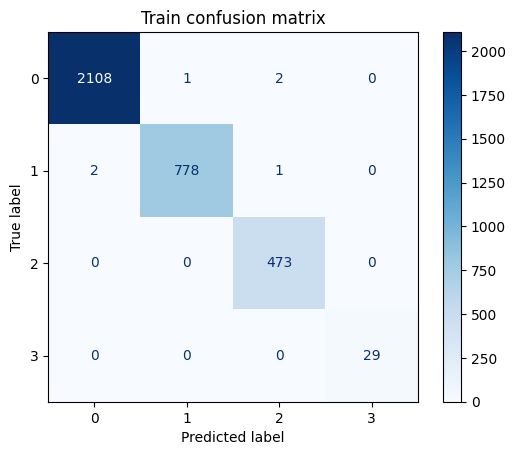

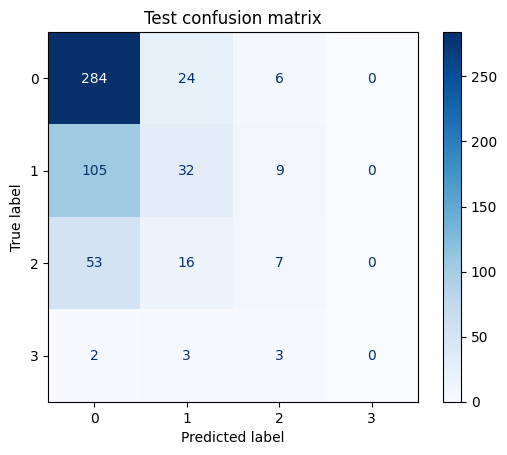

In [26]:
# Creazione del modello con i migliori parametri trovati dal grid search
model = RandomForestClassifier(**parameters)

# Allenamento del modello
model.fit(X_train_with_encoder, y_train)

# Predizione per il training e il test set
y_train_pred = model.predict(X_train_with_encoder)
y_test_pred = model.predict(X_test_with_encoder)

# Calcolo dell'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcolo della balanced accuracy per il training e il test
train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred)

# Aggiunta dei risultati alla lista dei modelli
models.append({ 
    'model_name': 'Random Forest',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampa delle metriche e della matrice di confusione
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred, "Train confusion matrix")
print_confusion_matrix(y_test, y_test_pred, "Test confusion matrix")


Della classe 3 non è stato in grado di predirne nessuno, anzi ha molto la tendenza a focalizzarsi sulla classe 0.

## Artifical Neural Network

In [27]:
# Conversione da una classe ad un array di probabilità per ciascuna classe
y_train_categorial = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorial = to_categorical(y_test, num_classes=len(np.unique(y_train)))

Definiamo una funzione `create_model(X_train, y_train, n_neurons=64, hidden_layer=1, dropout=True, activation='relu')`.

La funzione crea un modello neurale composto da:

1. Un layer di input di dimensioni pari al numero di caratteristiche di `X_train`.
2. Un numero di layer nascosti (`hidden_layer`), ciascuno con `n_neurons` neuroni e la funzione di attivazione specificata (`activation`). Se `dropout` è `True`, viene applicato un dropout del 25% al penultimo layer nascosto.
3. Un layer di output con un numero di neuroni pari al numero di classi uniche in `y_train`, con funzione di attivazione `softmax` per restituire un array di probabilità di appartenenza.

Il modello viene compilato utilizzando l'ottimizzatore Adam con un learning rate di 0.01, la funzione di perdita `categorical_crossentropy` e la metrica di valutazione `accuracy`.


In [28]:
# Creazione del modello
def create_model(X_train, y_train, n_neurons=64, hidden_layer=1, dropout=True, activation='relu'):
    # Verifica della presenza di almeno un layer nascosto
    if hidden_layer < 1:
        raise ValueError("There should be at least one hidden layer")

    # Inizializzazione del modello
    model = Sequential()
    # Aggiunta del layer di input
    model.add(Input(shape=(X_train.shape[1],)))

    # Aggiunta dei layer nascosti
    for i in range(hidden_layer - 1):
        model.add(Dense(n_neurons, activation=activation))
    
    # Aggiunta del Dropout (se abilitato)
    if dropout:
        model.add(Dropout(0.25))
        
    # Aggiunta dell'ultimo layer nascosto
    model.add(Dense(n_neurons, activation=activation))

    # Aggiunta del layer di output
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    # Compilazione del modello
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [29]:
# Definisci i pesi per ogni classe
weights_per_class = {
    0: [0.5, 0.8],
    1: [0.5, 0.8, 1],
    2: [1.5, 2],
    3: [1.5, 2]
}

# Crea una lista di tutte le combinazioni possibili di pesi
weight_combinations = list(itertools.product(*weights_per_class.values()))

# Funzione per ottenere i pesi dei campioni basata sulle combinazioni di pesi
def get_sample_weights(y, weight_combination, weights_per_class):
    sample_weights = np.zeros_like(y, dtype=float)
    for class_label, weight in zip(weights_per_class.keys(), weight_combination):
        # Trova gli indici dei campioni appartenenti a ciascuna classe
        class_indices = np.where(y == class_label)[0]
        # Assegna il peso appropriato a ciascun campione
        sample_weights[class_indices] = weight
    return sample_weights

# Parametri da testare
n_neurons_options = [32, 64]
hidden_layer_options = [1, 3, 5, 10]
dropout_options = [True, False]

# Variabili per tracciare i migliori risultati
best_score = -np.inf
best_params = {}

# Dato che sono già stati calcolati impostiamoli manualmente
n_neurons_options = [64]
hidden_layer_options = [5]
dropout_options = [True]
weight_combinations = [(0.5, 0.8, 1.5, 1.5)]

# Combinazione di tutte le possibili configurazioni di parametri
param_combinations = itertools.product(n_neurons_options, hidden_layer_options, dropout_options)

# Loop su tutte le combinazioni di parametri e pesi
for n_neurons, hidden_layer, dropout in param_combinations:
    for weight_combination in weight_combinations:
        print(f"Training con {n_neurons} neuroni, {hidden_layer} hidden layers, dropout={dropout}")
        print(f"Utilizzando la combinazione di pesi: {weight_combination}")

        # Ottieni i pesi per i campioni basati sulla combinazione corrente di pesi
        sample_weights = get_sample_weights(y_train, weight_combination, weights_per_class)

        # Crea il modello con i parametri correnti
        model = create_model(X_train_with_encoder, y_train, n_neurons=n_neurons, hidden_layer=hidden_layer, dropout=dropout)
        
        # Allena il modello
        model.fit(
            X_train_with_encoder, 
            y_train_categorial, 
            epochs=10, 
            batch_size=128, 
            verbose=0, 
            sample_weight=sample_weights  # Applica i pesi ai campioni
        )

        # Calcola le previsioni e la balanced accuracy per il training
        y_pred_train = model.predict(X_train_with_encoder)
        y_pred_train_numerical = np.argmax(y_pred_train, axis=1)  # Converte le previsioni one-hot in numeriche
        score_train = inverse_balanced_accuracy(np.argmax(y_train_categorial, axis=1), y_pred_train_numerical)
        
        # Calcola le previsioni e la balanced accuracy per il test
        y_pred_test = model.predict(X_test_with_encoder)
        y_pred_test_numerical = np.argmax(y_pred_test, axis=1)  # Converte le previsioni one-hot in numeriche
        score_test = inverse_balanced_accuracy(np.argmax(y_test_categorial, axis=1), y_pred_test_numerical)

        print(f"Balanced Accuracy Train: {score_train}")
        print(f"Balanced Accuracy Test: {score_test}")

        # Aggiorna i migliori parametri se si trova un punteggio migliore
        if score_test > best_score:
            best_score = score_test
            best_params = {
                'n_neurons': n_neurons,
                'hidden_layer': hidden_layer,
                'dropout': dropout,
                'weights': weight_combination
            }

# Stampa i migliori parametri e il punteggio migliore
print(f"Migliori parametri: {best_params}")
print(f"Punteggio migliore di balanced accuracy: {best_score}")


Training con 64 neuroni, 5 hidden layers, dropout=True
Utilizzando la combinazione di pesi: (0.5, 0.8, 1.5, 1.5)


W0000 00:00:1738775208.278696 3871172 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
Balanced Accuracy Train: 0.49023974100496026
Balanced Accuracy Test: 0.31268770751151487
Migliori parametri: {'n_neurons': 64, 'hidden_layer': 5, 'dropout': True, 'weights': (0.5, 0.8, 1.5, 1.5)}
Punteggio migliore di balanced accuracy: 0.31268770751151487


In [30]:
# Funzione per plottare la perdita e l'accuratezza durante l'allenamento
def plot_ann(history):
    # Plot della perdita (training e validazione)
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot dell'accuratezza (training e validazione)
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Crea il modello con i migliori parametri
model = create_model(
    X_train_with_encoder, y_train, 
    n_neurons=best_params['n_neurons'], 
    hidden_layer=best_params['hidden_layer'], 
    dropout=best_params['dropout']
)

# Callback per interrompere l'allenamento e ridurre il learning rate
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(verbose=1)

# Allenamento del modello
history = model.fit(
    X_train_with_encoder, y_train_categorial, 
    epochs=45, validation_data=(X_test_with_encoder, y_test_categorial),
    class_weight={i: best_params['weights'][i] for i in range(len(best_params['weights']))}, 
    callbacks=[lr_scheduler, early_stopping]
)

# Salvataggio del modello allenato
annModel = model

Epoch 1/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5502 - loss: 0.8189 - val_accuracy: 0.5570 - val_loss: 0.9493 - learning_rate: 0.0100
Epoch 2/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.5794 - loss: 0.7002 - val_accuracy: 0.5643 - val_loss: 0.9352 - learning_rate: 0.0100
Epoch 3/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.6509 - loss: 0.6380 - val_accuracy: 0.4835 - val_loss: 1.0501 - learning_rate: 0.0100
Epoch 4/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.6067 - loss: 0.6743 - val_accuracy: 0.5404 - val_loss: 1.0047 - learning_rate: 0.0100
Epoch 5/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.6324 - loss: 0.6618 - val_accuracy: 0.5386 - val_loss: 0.9957 - learning_rate: 0.0100
Epoch 6/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6337 - loss: 0.6627 - val_accuracy: 0.5349 - val_loss: 1.0091 - learning_rate: 0.0100
Epoch 7/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.6387 - los

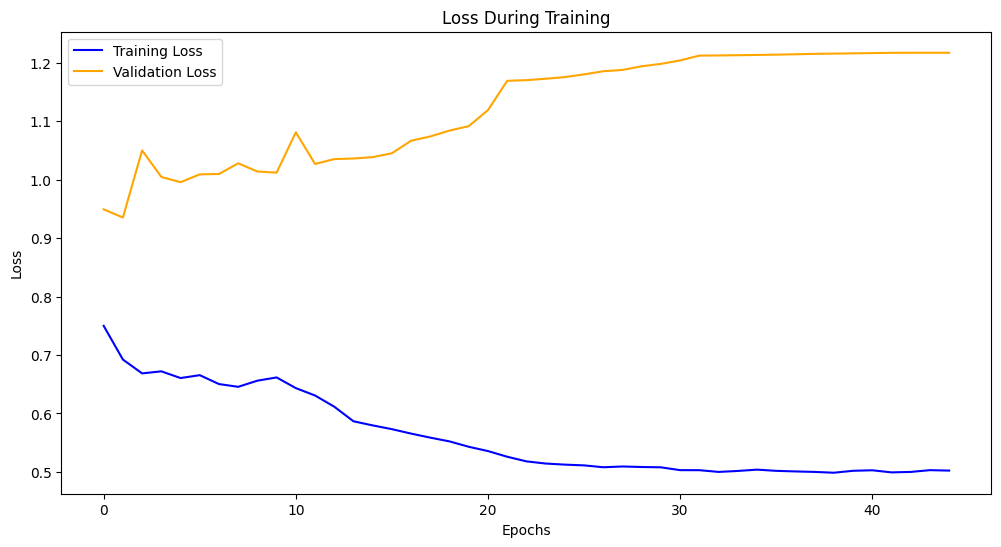

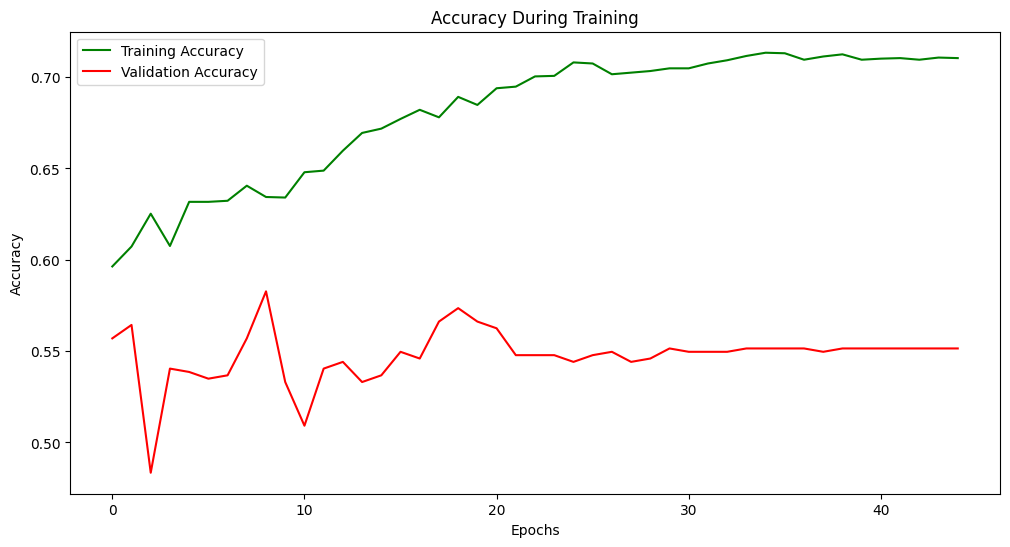

In [31]:
plot_ann(history)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Train Accuracy: 0.6562
Test Accuracy: 0.5643
Train Balanced Accuracy: 0.3957
Test Balanced Accuracy: 0.3403


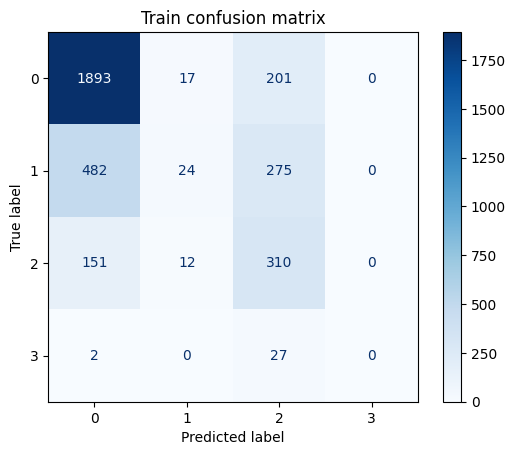

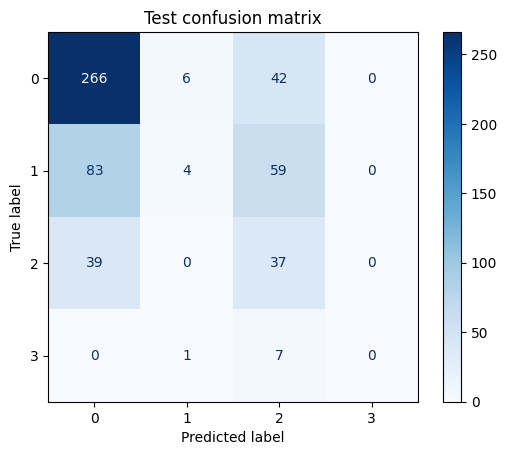

In [32]:
y_train_pred = model.predict(X_train_with_encoder)
y_test_pred = model.predict(X_test_with_encoder[X_train_with_encoder.columns])

# Converti le probabilità in etichette discrete (classi)
y_train_pred_label = np.argmax(y_train_pred, axis=1)
y_test_pred_label = np.argmax(y_test_pred, axis=1)

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred_label)

models.append({ 
    'model_name': 'ANN',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label, "Train confusion matrix")
print_confusion_matrix(y_test, y_test_pred_label, "Test confusion matrix")


Rispetto alla random forest il modello è generalmente migliore. 
Ha una tendenza a classificare 0 e 2.
Anche in questo caso non è riuscito a predirre la classe 3 e poco la classe 1.

# LightGBM

Poiché in precedenza è stato utilizzato il OneHotEncoder, ma LightGBM supporta direttamente le feature categoriali, ripetiamo il processo di preparazione dei dati, assicurandoci di utilizzare per il training le stesse istanze già selezionate in precedenza.


In [33]:
if len(ids) == 0:
    print("L'array di ids è vuoto!")

data = pd.read_csv('data/train.csv')
data = pre_processing(data)
data = instances_cleaning(data)
data = standardize_dataframe(data)

# Sepazione dell dataset in base agli 'id' per creare lo stesso set di allenamento e test
train = data[data['id'].isin(ids)]
test = data[~data['id'].isin(ids)]

train_without_encoder = train.drop(columns=['id'])
test_without_encoder = test.drop(columns=['id'])

X_train_without_encoder = train_without_encoder.drop(columns=['sii'])
y_train_without_encoder = train_without_encoder['sii']

X_test_without_encoder = test_without_encoder.drop(columns=['sii'])
y_test_without_encoder = test_without_encoder['sii']

X_train_filled_without_encoder = fill_missing_values(X_train_without_encoder)
X_test_filled_without_encoder = fill_missing_values(X_test_without_encoder)

X_train_without_encoder = data_cleaning(X_train_without_encoder)
X_test_without_encoder = data_cleaning(X_test_without_encoder)

y_train_without_encoder = fill_y_column(X_train_filled_without_encoder, y_train_without_encoder)


Colonne season rimosse: 10
Colonne rimosse: con 90.0% dei dati mancanti: 0, []
Righe rimosse con 90.0% dei dati mancanti: 3
Numero di righe con 'sii' null: 1224
Numero di righe rimosse: 27


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Numero di etichette aggiunte per ciascuna classe:
sii
0.0    614
1.0    473
2.0    131
3.0      3
Name: count, dtype: int64


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=300 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [34]:
# Crea lo scorer personalizzato
inverse_balanced_accuracy_scorer = make_scorer(inverse_balanced_accuracy, greater_is_better=True)

# Parametri da ottimizzare con Grid Search
# Ci mette troppo con la Grid Search, evitiamo di fare il tuning dei parametri
param_grid = {
    'learning_rate': [0.1],       # Tasso di apprendimento
    'num_leaves': [10],               # Numero di foglie
    'max_depth': [10],             # Profondità massima
    'n_estimators': [50]
    
}

# Crea il modello LightGBM
model = lgb.LGBMClassifier(
    is_unbalance=True,
    objective='multiclass',
    boosting_type='gbdt',                # Tipo di boosting
    metric= 'multi_error',                # Metrica di valutazione
    num_class= len(np.unique(y_train)),
    random_state=4
)

# Configura la Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=inverse_balanced_accuracy_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Esegui la Grid Search
grid_search.fit(X_train_without_encoder, y_train)

# Stampa i migliori parametri
print("Migliori Parametri Trovati:", grid_search.best_params_)

# Recupera il miglior modello
model = grid_search.best_estimator_

# Fare previsioni sul training e test set
y_train_pred = model.predict(X_train_without_encoder)
y_test_pred = model.predict(X_test_without_encoder)

# Convertire le probabilità in etichette
y_train_pred_label = y_train_pred
y_test_pred_label = y_test_pred

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 3394, number of used features: 23
[LightGBM] [Info] Start training from score -0.474847
[LightGBM] [Info] Start training from score -1.469189
[LightGBM] [Info] Start training from score -1.970669
[LightGBM] [Info] Start training from score -4.762469
Migliori Parametri Trovati: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 10}


Train Accuracy: 0.6880
Test Accuracy: 0.5699
Train Balanced Accuracy: 0.5516
Test Balanced Accuracy: 0.2477


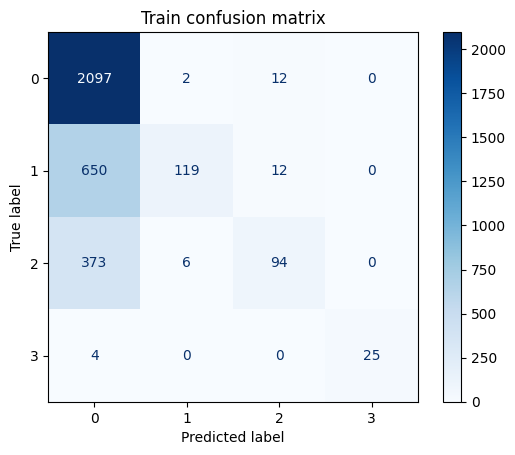

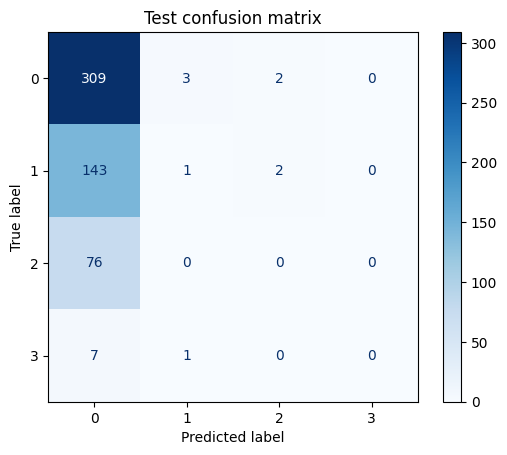

In [35]:
# Calcolare le metriche
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred_label)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred_label)

models.append({ 
    'model_name': 'lightgbm',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampare i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label, "Train confusion matrix")
print_confusion_matrix(y_test, y_test_pred_label, "Test confusion matrix")


I valori dei parametri sono stati scelti manualmente poiché il tuning richiedeva troppo tempo, è stata cercata una via di mezzo tra errori e overfitting.
Nella fase di training il modello si è comportato discretamente, nella fase di test si è focalizzato quasi unicamente sulla feature 0.

# Analisi dei Risultati  

Analizziamo il modello ANN, che ha ottenuto i migliori risultati, per individuare eventuali pattern nelle classificazioni corrette ed errate.  
Plottiamo le istanze classificate correttamente ed erroneamente per verificare se emergono feature distintive o distribuzioni anomali.


In [36]:
X_with_encoder = pd.concat([X_train_with_encoder], axis=0)
X_without_encoder = pd.concat([X_train_without_encoder], axis=0)

y = pd.concat([y_train], axis=0)
column_used = X_with_encoder.columns

In [37]:
#lgbmModel = next(model for model in models if model['model_name'] == 'lightgbm')['model']
#randomForestModel = next(model for model in models if model['model_name'] == 'Random Forest')['model']
annModel = next(model for model in models if model['model_name'] == 'ANN')['model']

# Previsioni sui dati
#y_pred_lgbm = [int(pred.argmax()) for pred in lgbmModel.predict(X_without_encoder)]
#y_pred_rf = randomForestModel.predict(X_with_encoder[randomForestModel.feature_names_in_])
y_pred_ann = annModel.predict(X_with_encoder).argmax(axis=1)

# Trova le istanze corrette e quelle errate
#mistakes = (y != y_pred_lgbm) & (y != y_pred_rf) & (y != y_pred_ann)  # Errate in tutti e tre i modelli
#correct = (y == y_pred_lgbm) & (y == y_pred_rf) & (y == y_pred_ann)  # Corrette in tutti e tre i modelli

mistakes = (y != y_pred_ann)
correct = (y == y_pred_ann)
# Verifica se ci sono sovrapposizioni
overlap = (mistakes & correct).sum()
if overlap > 0:
    print(f"ATTENZIONE: Ci sono {overlap} istanze che risultano sia corrette che errate! Controlla la logica.")
else:
    print("Nessuna sovrapposizione tra istanze corrette ed errate. La logica è corretta.")

# Output delle istanze errate
print(f"Numero di istanze errate: {mistakes.sum()}")

# Output delle istanze corrette
print(f"Numero di istanze correttamente: {correct.sum()}")

# Estrai le istanze corrette ed errate
correct_indices = correct[correct].index
incorrect_indices = mistakes[mistakes].index

#real_data = pd.read_csv('train.csv')
#real_data = pre_processing(real_data)
#real_data = instances_cleaning(real_data)
#real_data = data_cleaning(real_data)

#correct_features = X.loc[correct_indices]
#incorrect_features = X.loc[incorrect_indices]

X = X_with_encoder
correct_features = X.loc[correct_indices]
incorrect_features = X.loc[incorrect_indices]

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
Nessuna sovrapposizione tra istanze corrette ed errate. La logica è corretta.
Numero di istanze errate: 1167
Numero di istanze correttamente: 2227


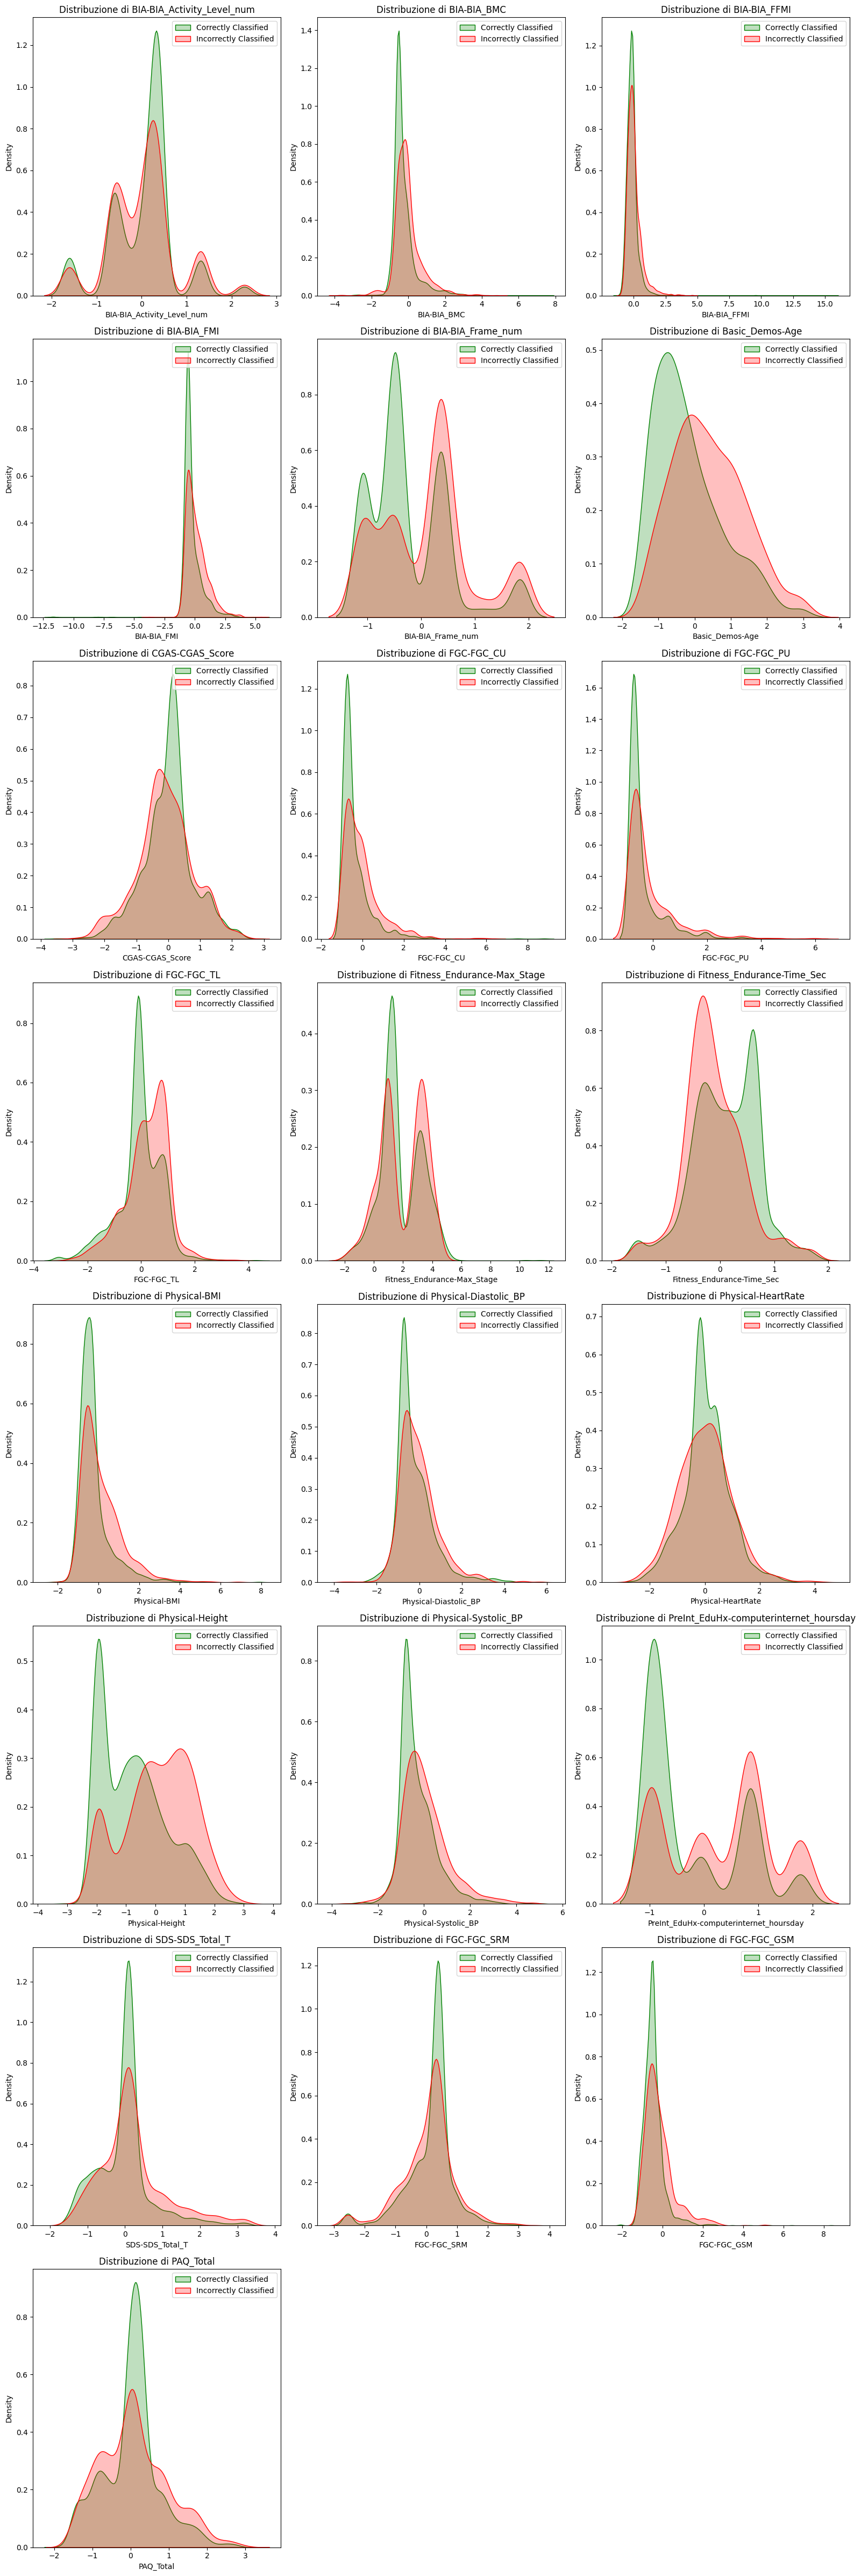

In [38]:
#Filtro sulle feature numeriche
numeric_features = [col for col in X.select_dtypes(include=['number']).columns if col in column_used]

# COnfigurazione del numero di righe e colonne per il grafico
num_features = len(numeric_features)
n_cols = 3
num_rows = (num_features // n_cols) + (1 if num_features % n_cols else 0)

plt.figure(figsize=(16, 6 * num_rows))  # Dimensione del grafico
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, n_cols, i)
    correct_data = correct_features[feature]
    incorrect_data = incorrect_features[feature]
        
    # Tracciamento della distribuzione
    sns.kdeplot(correct_data, label='Correctly Classified', color='green', fill=True)
    sns.kdeplot(incorrect_data, label='Incorrectly Classified', color='red', fill=True)
    plt.title(f'Distribuzione di {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

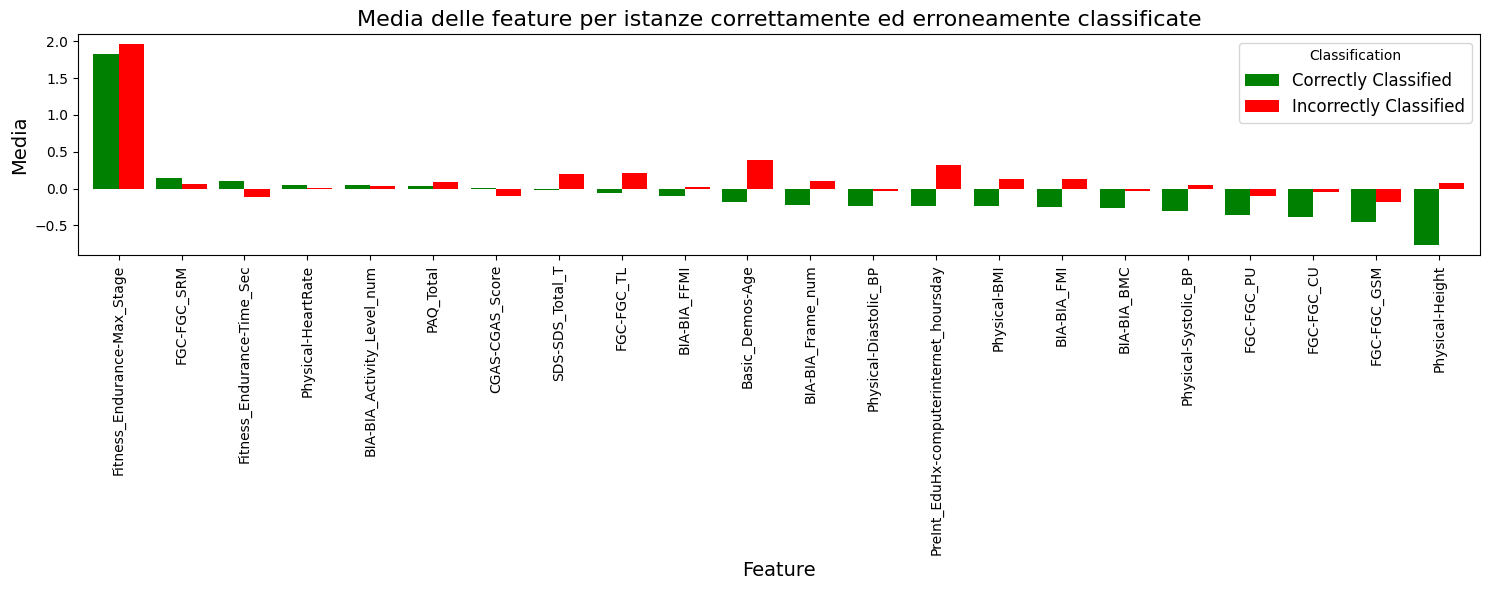

In [39]:
# Calcolo e visualizzazione della media delle feature
# Filtro delle colonne numeriche
numeric_features = [col for col in correct_features.select_dtypes(include=['number']).columns if col in column_used]
correct_numeric = correct_features[numeric_features]
incorrect_numeric = incorrect_features[numeric_features]

# Calcolo delle medie per le istanze corrette ed errate, ignorando i NaN
correct_means = correct_numeric.mean()
incorrect_means = incorrect_numeric.mean()

# Creazione di un DataFrame combinato con la media delle feature
df_means = pd.DataFrame({
    'Correctly Classified': correct_means,
    'Incorrectly Classified': incorrect_means
})

# Ordinamento dei dati per rendere il grafico più leggibile
df_means = df_means.sort_values(by='Correctly Classified', ascending=False)

# Plot delle medie delle feature
plt.figure(figsize=(15, 8))
df_means.plot(kind='bar', width=0.8, figsize=(15, 6), color=['green', 'red'])

# Aggiunta delle etichette e titoli
plt.title('Media delle feature per istanze correttamente ed erroneamente classificate', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Media', fontsize=14)
plt.xticks(rotation=90)

# Aggiunta della legenda
plt.legend(title='Classification', fontsize=12)
plt.tight_layout()

plt.show()


Dall'analisi delle distribuzioni, non emergono differenze significative tra le istanze classificate correttamente e quelle erroneamente. In effetti, nella maggior parte dei grafici, le distribuzioni delle classi positive e negative si sovrappongono.

Le uniche caratteristiche che mostrano distribuzioni leggermente differenti tra le istanze classificate correttamente ed erroneamente sono:

- **Basic Demos-Age**
- **Physical-Height**
- **Preint_EduHx-computerinternet_hoursday**
- **Basic_Demos-Age**

Per queste feature, si osserva che valori più alti tendono ad essere associati a un numero maggiore di errori di classificazione, mentre valori più bassi risultano in una classificazione corretta.

Al contrario, **Fitness_Endurance-Time_Sec** mostra un comportamento opposto: i valori bassi sono associati a un maggior numero di errori, mentre i valori più alti tendono a risultare in meno errori di classificazione.

Queste osservazioni sono ulteriormente confermate dal secondo grafico.
